Given a date, displays the injected gas meter volume and its respective percentage the gas valve is open

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

what's the name of your file?  gallant.csv


The dates in this file are from 2024-10-04 to 2024-10-11.


Which day would you like to inspect? Type in YYYY-MM-DD. 2024-10-05


/var/folders/l5/dsrjn7997_qdzvtnv5k825r40000gq/T/ipykernel_65661/1640955997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['Inj Gas Valve Percent Open'] = day['Inj Gas Valve Percent Open'].interpolate(method='linear')
/var/folders/l5/dsrjn7997_qdzvtnv5k825r40000gq/T/ipykernel_65661/1640955997.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['Inj Gas Meter Volume Instantaneous'] = day['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')
/opt/anaconda3/lib/python3.11/site-packa

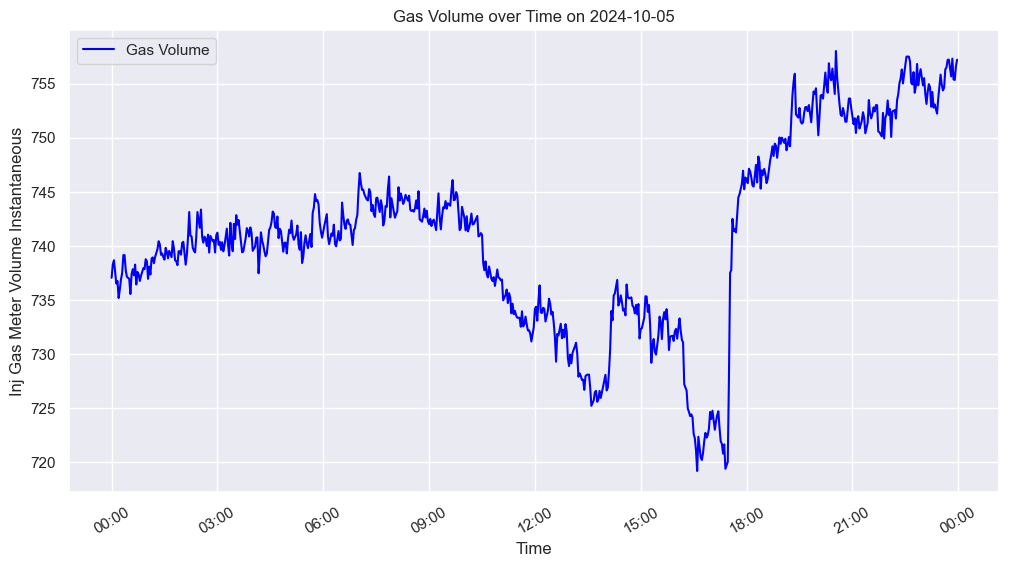

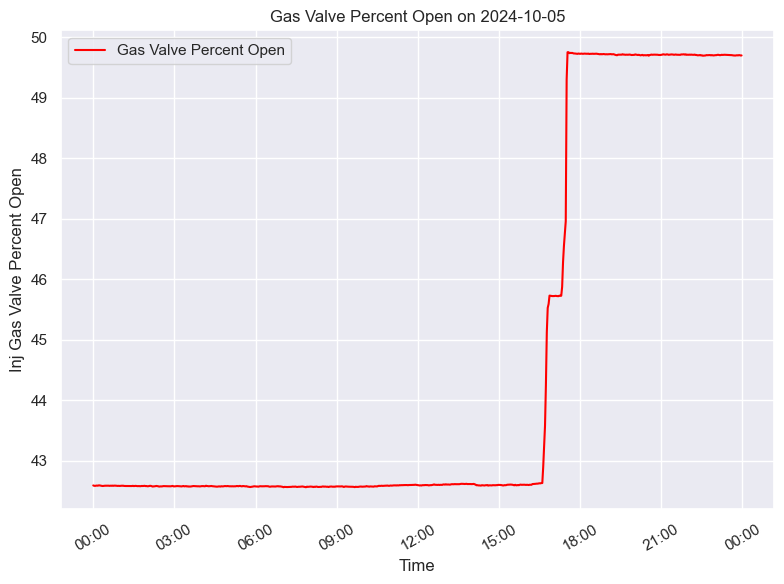

In [63]:
name = input("what's the name of your file? ")
data = pd.read_csv(name) # reads csv file

# convert the 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y %I:%M:%S %p')

start = data['Time'].iloc[0].date()
end = data['Time'].iloc[-1].date() 
print(f"The dates in this file are from {start} to {end}.")

# filter over a single day: YYYY-MM-DD testing - 2024-10-31
input_date = input("Which day would you like to inspect? Type in YYYY-MM-DD.")
day = data[data['Time'].dt.date == pd.to_datetime(input_date).date()]

day['Inj Gas Valve Percent Open'] = day['Inj Gas Valve Percent Open'].interpolate(method='linear')
day['Inj Gas Meter Volume Instantaneous'] = day['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')
# print(day[['Time', 'Inj Gas Valve Percent Open', 'Inj Gas Meter Volume Instantaneous']])

sns.set_theme()

# plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Time', y='Inj Gas Meter Volume Instantaneous', data=day, ax=ax1, color='blue', label='Gas Volume')

# only time
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

ax1.set_xlabel('Time')
ax1.set_ylabel('Inj Gas Meter Volume Instantaneous')
plt.title(f"Gas Volume over Time on {input_date}")
plt.xticks(rotation=30)

fig_percent, ax2 = plt.subplots(figsize=(8,6))
sns.lineplot(x='Time', y='Inj Gas Valve Percent Open', data=day, ax=ax2, color='red', label='Gas Valve Percent Open')
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
ax2.set_ylabel('Inj Gas Valve Percent Open')
plt.title(f"Gas Valve Percent Open on {input_date}")
plt.xticks(rotation=30)
plt.tight_layout()

plt.show()

In [66]:
# time to datetime
day['Time'] = pd.to_datetime(day['Time'], format='%m/%d/%Y %I:%M:%S %p')

# # Filter for a single day
input_date = input("Enter the date (YYYY-MM-DD): ")  # Example: '2024-10-31'
day = data[data['Time'].dt.date == pd.to_datetime(input_date).date()]

day['Inj Gas Valve Percent Open'] = day['Inj Gas Valve Percent Open'].interpolate(method='linear')
day['Inj Gas Meter Volume Instantaneous'] = day['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')

setpoint_value = data['Inj Gas Meter Volume Setpoint'].dropna().iloc[0]
print(setpoint_value)
data['Inj Gas Meter Volume Setpoint'] = setpoint_value

# error between the instantaneous gas meter volumes and setpoint
day['Error'] = day['Inj Gas Meter Volume Instantaneous'] - day['Inj Gas Meter Volume Setpoint']
data.head()

#'Hydrate_Formed' based on these conditions
day['Hydrate_Formed'] = (
     (day['Inj Gas Valve Percent Open'] < 35) &
     (day['Error'] > 15)
 )
day['Hydrate_Formed'] = day['Hydrate_Formed'].astype(int)
print(day)

/var/folders/l5/dsrjn7997_qdzvtnv5k825r40000gq/T/ipykernel_65661/759408751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['Time'] = pd.to_datetime(day['Time'], format='%m/%d/%Y %I:%M:%S %p')


Enter the date (YYYY-MM-DD):  2024-10-31


750.0
Empty DataFrame
Columns: [Time, Inj Gas Meter Volume Instantaneous, Inj Gas Meter Volume Setpoint, Inj Gas Valve Percent Open, Error, Hydrate_Formed]
Index: []


logistic regression to predict whether hydrate will form or not.

In [61]:
name = input("what's the name of your file? ")
data = pd.read_csv(name) # reads csv file

# time to datetime
data['Time'] = pd.to_datetime(data['Time'])


# interpolation for missing percentage values
data['Inj Gas Valve Percent Open'] = data['Inj Gas Valve Percent Open'].interpolate(method='linear')
data['Inj Gas Meter Volume Instantaneous'] = data['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')

setpoint_value = data['Inj Gas Meter Volume Setpoint'].dropna().iloc[0]
print(setpoint_value)
data['Inj Gas Meter Volume Setpoint'] = setpoint_value

# error between the instantaneous gas meter volumes and setpoint
data['Error'] = data['Inj Gas Meter Volume Instantaneous'] - data['Inj Gas Meter Volume Setpoint']
data.head()


# sample thresholds to determine hydrate formation
high_volume_threshold = data['Inj Gas Meter Volume Instantaneous'].quantile(0.80)  # top 20% as "high volume"
low_percent_threshold = data['Inj Gas Valve Percent Open'].quantile(0.10)  # bottom 25% as "low percent"


# 'Hydrate_Formed' based on these conditions
data['Hydrate_Formed'] = (
    (data['Inj Gas Meter Volume Instantaneous'] > high_volume_threshold) &
    (data['Inj Gas Valve Percent Open'] < low_percent_threshold) &
    (data['Error'] > 0)
)
data['Hydrate_Formed'] = data['Hydrate_Formed'].astype(int)
data.head(50)

X = data[['Inj Gas Valve Percent Open', 'Error', 'Inj Gas Meter Volume Instantaneous']]
y = data['Hydrate_Formed']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)
print(X_train, y_train)
model.predict(X_test)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

what's the name of your file?  gallant.csv


/var/folders/l5/dsrjn7997_qdzvtnv5k825r40000gq/T/ipykernel_65661/958420573.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time'])


750.0


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

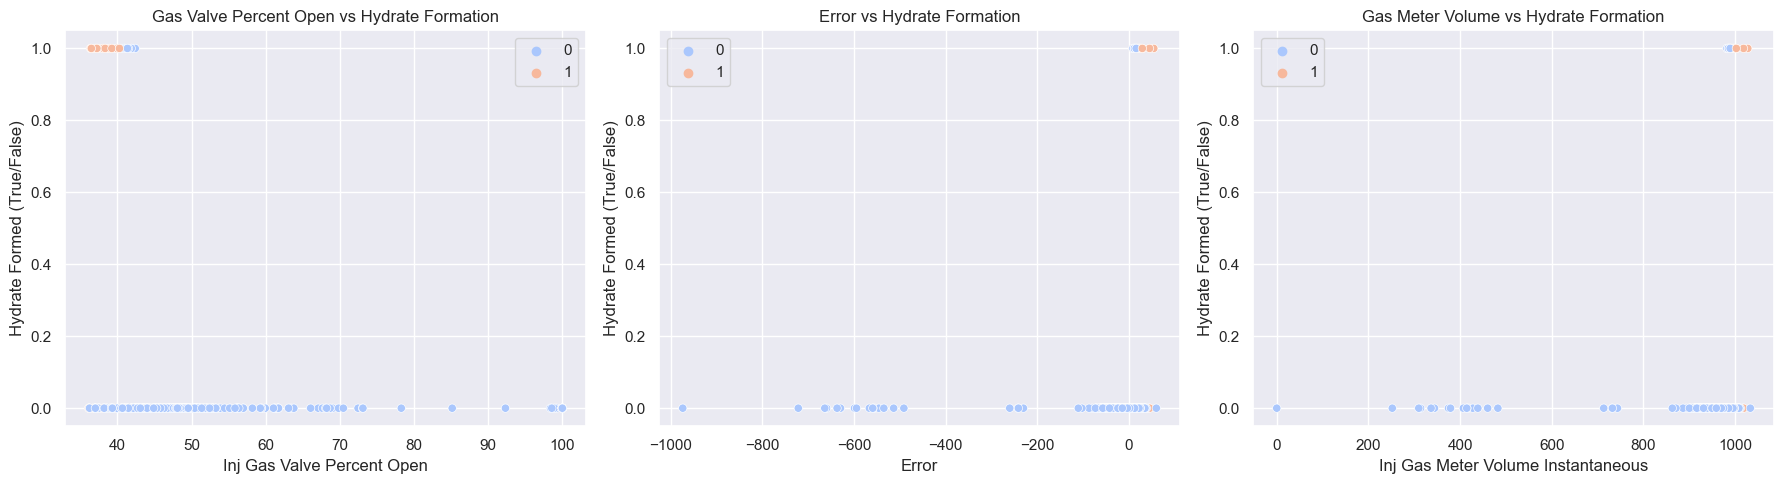

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust size as needed


# Scatter plot for 'Inj Gas Valve Percent Open'
sns.scatterplot(data=X_test, x='Inj Gas Valve Percent Open', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[0])
axes[0].set_title('Gas Valve Percent Open vs Hydrate Formation')
axes[0].set_xlabel('Inj Gas Valve Percent Open')
axes[0].set_ylabel('Hydrate Formed (True/False)')


# Scatter plot for 'Error'
sns.scatterplot(data=X_test, x='Error', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[1])
axes[1].set_title('Error vs Hydrate Formation')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Hydrate Formed (True/False)')


# Scatter plot for 'Inj Gas Meter Volume Instantaneous'
sns.scatterplot(data=X_test, x='Inj Gas Meter Volume Instantaneous', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[2])
axes[2].set_title('Gas Meter Volume vs Hydrate Formation')
axes[2].set_xlabel('Inj Gas Meter Volume Instantaneous')
axes[2].set_ylabel('Hydrate Formed (True/False)')


# Show the plots
plt.tight_layout()
plt.show()
